# H&M Fashion Dataset
a notebook to explore the [H&M Fashion dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations) in order to prepare a `Dataset` class and `Dataloader` 

note that I've tried to find a link between the articles in this dataset and those from their web page (e.g. the [US store](https://www2.hm.com/en_us/index.html)) and couldnt find links yet.


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
import json
import pandas as pd
%matplotlib inline

!which python

/bin/bash: /home/guy/anaconda3/envs/dis_ir/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/guy/anaconda3/envs/dis_ir/bin/python


In [2]:
# set the dataset_path
if os.uname()[1]=='guy-x':
    dataset_path = '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations'
else:   # assuming gpu15
    dataset_path = '/data/users/gkoren2/datasets/h-and-m-personalized-fashion-recommendation'       # gpu15

print(f"assuming we're on {os.uname()[1]} so data is in {dataset_path}")



assuming we're on guy-x so data is in /home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations


In [17]:
# option 1 to handle images 
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_grid2(imgs, nrows = 1, ncols=1,figsize=(16, 16)):
    """Plot a dictionary of Image objects.

    Parameters
    ----------
    figures : dict of Image objects
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,aid in enumerate(imgs):
        axeslist.ravel()[ind].imshow(imgs[aid])
        axeslist.ravel()[ind].set_title(aid)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional


# Exploration
Description provided by the site:
- images/ - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.
- articles.csv - detailed metadata for each article_id available for purchase
- customers.csv - metadata for each customer_id in dataset
- sample_submission.csv - a sample submission file in the correct format
- transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

In [46]:
# option 2 to handle images
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return dataset_path+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized


def load_image2(img, resize = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    if isinstance(resize,float):
        resized = cv2.resize(img, (int(h*resize), int(w*resize)), interpolation = cv2.INTER_AREA)
    elif isinstance(resize,int):
        resized = cv2.resize(img, (int(resize), int(resize)), interpolation = cv2.INTER_AREA)
    else:  # tuple (h,w)
        resized = cv2.resize(img, (int(resize[0]), int(resize[1])), interpolation = cv2.INTER_AREA)
    return resized

## Annotations

### Items

In [3]:
adf = pd.read_csv(dataset_path + "/articles.csv",on_bad_lines='skip')
# df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# df = df.reset_index(drop=True)
print(adf.shape)
adf.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [60]:
np.any(['1087261006' in str(a) for a in adf['article_id'].values])

False

In [62]:
query = ['Oversized Hoodie' in str(a) for a in adf['detail_desc'].values]
adf.loc[query,:]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc


In [4]:
adf.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [47]:
# measure how many unique values in each column:
{c:len(adf[c].value_counts()) for c in adf.columns}

{'article_id': 105542,
 'product_code': 47224,
 'prod_name': 45875,
 'product_type_no': 132,
 'product_type_name': 131,
 'product_group_name': 19,
 'graphical_appearance_no': 30,
 'graphical_appearance_name': 30,
 'colour_group_code': 50,
 'colour_group_name': 50,
 'perceived_colour_value_id': 8,
 'perceived_colour_value_name': 8,
 'perceived_colour_master_id': 20,
 'perceived_colour_master_name': 20,
 'department_no': 299,
 'department_name': 250,
 'index_code': 10,
 'index_name': 10,
 'index_group_no': 5,
 'index_group_name': 5,
 'section_no': 57,
 'section_name': 56,
 'garment_group_no': 21,
 'garment_group_name': 21,
 'detail_desc': 43404}

In [50]:
adf['product_type_name'].value_counts()
# adf['product_type_name'].hist()

Trousers         11169
Dress            10362
Sweater           9302
T-shirt           7904
Top               4155
                 ...  
Keychain             1
Headband             1
Cushion              1
Blanket              1
Clothing mist        1
Name: product_type_name, Length: 131, dtype: int64

In [22]:
adf['product_group_name'].value_counts()

Garment Upper body       42741
Garment Lower body       19812
Garment Full body        13292
Accessories              11158
Underwear                 5490
Shoes                     5283
Swimwear                  3127
Socks & Tights            2442
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [53]:
adf['perceived_colour_master_name'].value_counts()

Black              22585
Blue               18469
White              12665
Pink                9403
Grey                8924
Red                 5878
Beige               5657
Green               3526
Khaki green         3181
Yellow              3121
Orange              2734
Brown               2269
Metal               2180
Turquoise           1829
Mole                1223
Lilac Purple        1100
Unknown              685
undefined            105
Yellowish Green        5
Bluish Green           3
Name: perceived_colour_master_name, dtype: int64

In [54]:
adf['perceived_colour_value_name'].value_counts()

Dark            42706
Dusty Light     22152
Light           15739
Medium Dusty    12630
Bright           6471
Medium           5711
Undefined         105
Unknown            28
Name: perceived_colour_value_name, dtype: int64

In [51]:
adf['colour_group_name'].value_counts()

Black              22670
Dark Blue          12171
White               9542
Light Pink          5811
Grey                4487
Light Beige         3356
Blue                3308
Red                 3056
Light Blue          3012
Greenish Khaki      2767
Dark Grey           2731
Off White           2726
Beige               2712
Dark Red            2340
Dark Green          2106
Light Grey          2105
Pink                2063
Yellow              1645
Light Orange        1520
Yellowish Brown     1471
Gold                1377
Dark Beige          1084
Light Turquoise     1027
Light Yellow         984
Dark Orange          886
Dark Pink            818
Green                815
Orange               779
Other Pink           750
Silver               709
Light Green          681
Dark Yellow          574
Light Purple         553
Dark Turquoise       473
Turquoise            435
Dark Purple          315
Light Red            285
Greyish Beige        226
Other Yellow         225
Purple               182


In [52]:
adf['graphical_appearance_name'].value_counts()

Solid                  49747
All over pattern       17165
Melange                 5938
Stripe                  4990
Denim                   4842
Front print             3215
Placement print         3098
Check                   2178
Colour blocking         1830
Lace                    1513
Other structure         1502
Application/3D          1341
Embroidery              1165
Mixed solid/pattern     1132
Glittering/Metallic      958
Jacquard                 830
Sequin                   806
Dot                      681
Treatment                586
Other pattern            515
Contrast                 376
Metallic                 346
Chambray                 322
Slub                     153
Transparent               86
Mesh                      86
Neps                      66
Unknown                   52
Argyle                    15
Hologram                   8
Name: graphical_appearance_name, dtype: int64

In [23]:
adf['department_name'].value_counts()

Jersey                             4604
Knitwear                           3503
Trouser                            2655
Blouse                             2362
Dress                              2087
                                   ... 
Woven bottoms inactive from S.7       1
Jersey inactive from S.6              1
EQ Divided Blue                       1
Accessories Other                     1
Kids Boy License                      1
Name: department_name, Length: 250, dtype: int64

In [55]:
adf['garment_group_name'].value_counts()

Jersey Fancy                     21445
Accessories                      11519
Jersey Basic                      8126
Knitwear                          7490
Under-, Nightwear                 7441
Trousers                          6727
Blouses                           5838
Shoes                             5145
Dresses Ladies                    4874
Outdoor                           4501
Unknown                           3873
Trousers Denim                    3100
Swimwear                          2787
Socks and Tights                  2272
Shirts                            2116
Woven/Jersey/Knitted mix Baby     1965
Shorts                            1559
Dresses/Skirts girls              1541
Skirts                            1254
Special Offers                    1061
Dressed                            908
Name: garment_group_name, dtype: int64

### users

In [10]:
cdf = pd.read_csv(dataset_path + "/customers.csv",on_bad_lines='skip')
# df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# df = df.reset_index(drop=True)
print(cdf.shape)
cdf.head(10)

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.0,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


### Transactions

In [11]:
trdf = pd.read_csv(dataset_path + "/transactions_train.csv",on_bad_lines='skip')
# df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# df = df.reset_index(drop=True)
print(trdf.shape)
trdf.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [56]:
trdf['customer_id'].value_counts()

be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
                                                                    ... 
63b70b71291668f0a63ade8e321fb3eccb80eba164f2087dad471de065f18e1f       1
950b172c36d169bf427545991fe66371f21a085799b44780fdcb2da6a3091613       1
7c284f13f4af9d6a53f97279381638ed0cb7afaa4fd4f3eaadc21993ea45fc69       1
62d49d0ae11a4f65fa31e354cb87f6b557ebec648e0e5e71435d2dd190d1ccc4       1
268eaa31a07d6f2f4f060bfcf32a660f3ea3dbb21ef14cd09fc2545f4e0b5c10       1
Name: customer_id, Length: 1362281, dtype: int64

In [14]:
cdf=trdf.loc[trdf['customer_id']=='be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b',:]
cdf

,t_dat,customer_id,article_id,price,sales_channel_id
83738,2018-09-21,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,658506001,0.059305,1
83739,2018-09-21,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,662980002,0.033881,1
109160,2018-09-22,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,667709001,0.050831,2
109161,2018-09-22,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,685687001,0.016932,2
109162,2018-09-22,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,685687001,0.016932,2
...,...,...,...,...,...
31541312,2020-09-15,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,886566001,0.033881,2
31541313,2020-09-15,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,886566001,0.033881,2
31541314,2020-09-15,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,904965002,0.042356,2
31541315,2020-09-15,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,926502001,0.059305,2


In [77]:
cdf['t_dat'].value_counts(sort=False)

2018-09-21     2
2018-09-22     6
2018-09-26     8
2018-09-29    14
2018-10-04     5
              ..
2020-09-04     4
2020-09-05     7
2020-09-10    11
2020-09-12     1
2020-09-15     7
Name: t_dat, Length: 293, dtype: int64

in an attempt to see if there's a sense in session-inzation by date, lets have a look at all items that a customer purchased in 2 different days and see if we can cluster them:


In [66]:
cdf.head()

,t_dat,customer_id,article_id,price,sales_channel_id
83738,2018-09-21,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,658506001,0.059305,1
83739,2018-09-21,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,662980002,0.033881,1
109160,2018-09-22,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,667709001,0.050831,2
109161,2018-09-22,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,685687001,0.016932,2
109162,2018-09-22,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,685687001,0.016932,2


In [78]:
day1_arts=cdf.loc[cdf['t_dat']=='2020-09-10','article_id'].values
day2_arts=cdf.loc[cdf['t_dat']=='2018-09-26','article_id'].values

print(day1_arts)
print(day2_arts)

[730683054 816746001 816746001 915453002 926502001 956217002 915453003
 904422001 909371001 748566027 863646001]
[580482002 637515001 637515005 682813002 681620001 662980001 561500002
 554640001]


|        |   article_id |   product_code | prod_name                 |   product_type_no | product_type_name   | product_group_name   |   graphical_appearance_no | graphical_appearance_name   |   colour_group_code | colour_group_name   |   perceived_colour_value_id | perceived_colour_value_name   |   perceived_colour_master_id | perceived_colour_master_name   |   department_no | department_name      | index_code   | index_name   |   index_group_no | index_group_name   |   section_no | section_name               |   garment_group_no | garment_group_name   | detail_desc                                                                                                                                                                                                                                                      |
|-------:|-------------:|---------------:|:--------------------------|------------------:|:--------------------|:---------------------|--------------------------:|:--------------

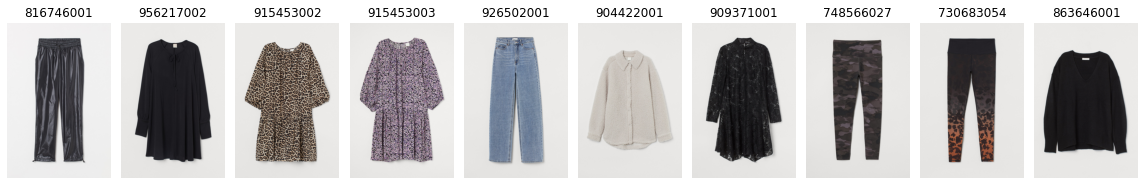

In [131]:
get_imgs_by_aid(day1_arts)

       article_id  product_code               prod_name  product_type_no  \
12761   554640001        554640              Skirt Torn              275   
14091   561500002        561500   Annie LOUNGE Trousers              296   
18785   580482002        580482                   Grace              265   
33134   637515001        637515                   Matey              252   
33138   637515005        637515                   Matey              252   
39896   662980001        662980                   Jafar              252   
44921   681620001        681620            AK JADE cord              272   
45305   682813002        682813  Trouser Socks 2p Socks              302   

      product_type_name  product_group_name  graphical_appearance_no  \
12761             Skirt  Garment Lower body                  1010023   
14091     Pyjama bottom           Nightwear                  1010001   
18785             Dress   Garment Full body                  1010010   
33134           Sweater  Ga

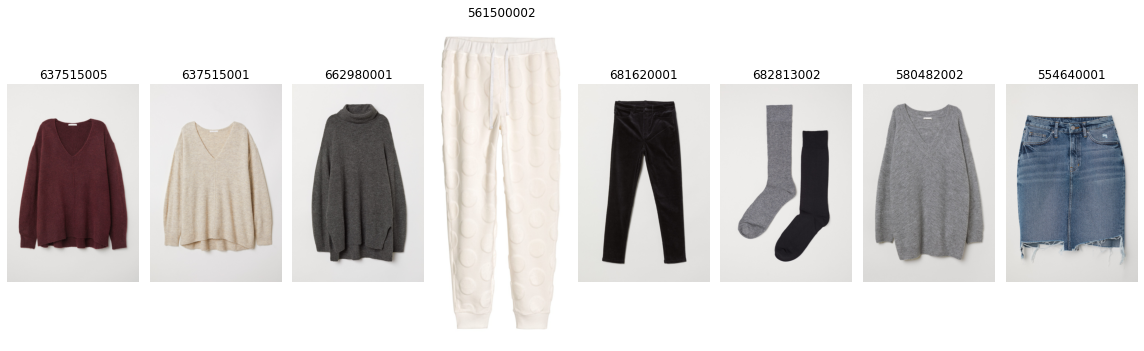

In [80]:
get_imgs_by_aid(day2_arts)

In [73]:
pd.concat([adf.loc[adf['article_id']==a] for a in day1_arts])

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
60134,726923003,726923,Xtina Bandeau,298,Bikini top,Swimwear,1010026,Other structure,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Non-wired bandeau bikini top with a decorative...
83378,811907011,811907,Sporty spice top,298,Bikini top,Swimwear,1010016,Solid,93,Dark Green,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini top with removable inserts ...
98898,881362002,881362,Zoey tunic,258,Blouse,Garment Upper body,1010001,All over pattern,73,Dark Blue,...,Blouse,A,Ladieswear,1,Ladieswear,6,Womens Casual,1010,Blouses,Tunic in an airy cotton weave with a small sta...
98898,881362002,881362,Zoey tunic,258,Blouse,Garment Upper body,1010001,All over pattern,73,Dark Blue,...,Blouse,A,Ladieswear,1,Ladieswear,6,Womens Casual,1010,Blouses,Tunic in an airy cotton weave with a small sta...
86255,823168006,823168,Sporty Spice Highwaist Brazil,59,Swimwear bottom,Swimwear,1010016,Solid,93,Dark Green,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Fully lined, waist-high bikini bottoms with hi..."
98595,879996001,879996,My Humps Highwaist,59,Swimwear bottom,Swimwear,1010016,Solid,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Fully lined, waist-high bikini bottoms with wi..."
98595,879996001,879996,My Humps Highwaist,59,Swimwear bottom,Swimwear,1010016,Solid,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Fully lined, waist-high bikini bottoms with wi..."
57078,715624050,715624,Becka hoodie,308,Hoodie,Garment Upper body,1010016,Solid,62,Purple,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Long-sleeved top in soft sweatshirt fabric wit...
94225,861478002,861478,Clean Bandit Highwaist,59,Swimwear bottom,Swimwear,1010016,Solid,93,Dark Green,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Fully lined, waist-high bikini bottoms with a ..."
59458,723529001,723529,Lazer Razer Adj. push triangle,298,Bikini top,Swimwear,1010016,Solid,9,Black,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Triangle bikini top with scalloped trims and g...


## images

In [16]:
img_fn=[i for i in Glob(f'{dataset_path}/images/**/*.jpg',recursive=True)]
len(img_fn)

105100

In [129]:
adf = pd.read_csv(dataset_path + "/articles.csv",on_bad_lines='skip')
# adf['img_fn'] = adf.apply(lambda row: dataset_path+'/images/0'+str(row['article_id'])[:2]+'/0'+str(row['article_id']) + ".jpg", axis=1)
def get_imgs_by_aid(aid_list,size=(512,512)):
    aid_df = adf.loc[adf['article_id'].isin(aid_list),:]
    ifn={str(a):f for f in img_fn for a in aid_list if str(a) in f }
    imgs = {os.path.splitext(os.path.basename(a))[0]:Image.open(ifn[a]) for a in ifn}
    [i.thumbnail(size) for i in imgs.values()]
    print(aid_df.to_markdown())
    image_grid2(imgs,1,len(imgs))


    article_id  product_code          prod_name  product_type_no  \
10   111609001        111609  200 den 1p Tights              304   
11   112679048        112679     SWEATSHIRT  OC              252   
12   112679052        112679     SWEATSHIRT  OC              252   
13   114428026        114428  Alice BANDEAU 2-p              306   
14   114428030        114428  Alice BANDEAU 2-p              306   
15   116379047        116379  Frugan longsleeve              254   

   product_type_name  product_group_name  graphical_appearance_no  \
10  Underwear Tights      Socks & Tights                  1010016   
11           Sweater  Garment Upper body                  1010001   
12           Sweater  Garment Upper body                  1010001   
13               Bra           Underwear                  1010017   
14               Bra           Underwear                  1010016   
15               Top  Garment Upper body                  1010016   

   graphical_appearance_name  colour_gr

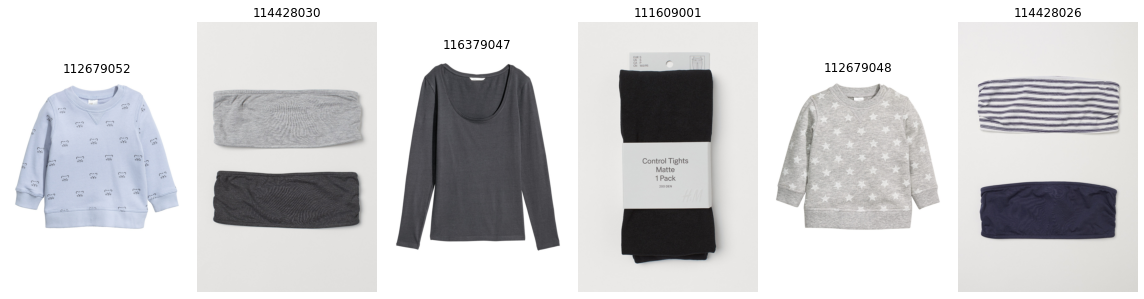

In [19]:
aid_list=adf.loc[10:15,'article_id'].values
get_imgs_by_aid(aid_list)

In [ ]:
def create_square_img(img,size):
    
    old_size = img.size  # old_size[0] is in (width, height) format

    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = img.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (size, size))
    new_im.paste(im, ((size-new_size[0])//2,
                        (size-new_size[1])//2))
    return new_im    

In [127]:
import cv2
def create_square_img2(img,size,border_type=cv2.BORDER_CONSTANT,border_value=(255,255,255)):
    '''
    border_type can also be cv2.BORDER_REPLICATE
    '''
    old_size = img.size  # old_size[0] is in (width, height) format
    print(f'original size: {old_size}')
    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)
    im = img.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    im = np.array(im)
    if border_type==cv2.BORDER_CONSTANT:
        im = cv2.copyMakeBorder(im,(size-new_size[1])//2,(size-new_size[1])//2,(size-new_size[0])//2,(size-new_size[0])//2,cv2.BORDER_CONSTANT,value=border_value)
    else:
        im = cv2.copyMakeBorder(im,(size-new_size[1])//2,(size-new_size[1])//2,(size-new_size[0])//2,(size-new_size[0])//2,border_type)

    new_im = Image.fromarray(im)
    return new_im    

In [92]:
imgs={os.path.splitext(os.path.basename(im))[0]:Image.open(im) for im in img_fn[15:19]}
# [imgs[im].thumbnail((256,256)) for im in imgs]
# image_grid2(imgs,1,4)
imgs.keys()

dict_keys(['0609319002', '0608013004', '0600229004', '0605094020'])

In [91]:
[imgs[im].size for im in imgs]

[(1166, 1750), (1166, 1750), (1416, 1750), (1166, 1750)]

In [104]:
list(imgs['0609319002'].getdata())[0]

(223, 221, 224)

original size: (1166, 1750)


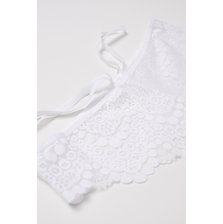

In [128]:
create_square_img2(imgs['0609319002'],224)

In [107]:
size=224
img=imgs['0609319002']
old_size = img.size  # old_size[0] is in (width, height) format
print(f'original size: {old_size}')
ratio = float(size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])
im = img.resize(new_size, Image.ANTIALIAS)
im = np.array(im)

original size: (1166, 1750)


In [116]:
tuple(im[0,0])

(223, 222, 224)

In [86]:
imsz = [Image.open(im).size for im in img_fn]
pd.Series(imsz).value_counts()
# plt.imshow(img)

(1166, 1750)    93377
(1167, 1750)      217
(1166, 1749)       51
(1352, 1750)       21
(1300, 1750)       20
                ...  
(2880, 1749)        1
(1524, 1749)        1
(2674, 1750)        1
(2665, 1750)        1
(1714, 1749)        1
Length: 2804, dtype: int64

In [87]:
1166/1750

0.6662857142857143

In [ ]:
# find image with a given size
im=[img_fn[i] for i in range(len(img_fn)) if imsz[i] == (480,640) ]
Image.open(im[0])

In [ ]:
# find images with a given id
im=[img_fn[i] for i in range(len(img_fn)) if imsz[i] == (480,640) ]
Image.open(im[0])

In [ ]:
img_fn[:10]

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
imgs = [Image.open(im) for im in img_fn[100:110]]
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
image_grid(imgs,2,5)

In [ ]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# Dataset Class
The goal is to prepare a dataset class and dataloader that we can use to train the VAE models in PyTorchVAE.

In [ ]:
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

## Dataset Normalization
in order to normalize the dataset, we could either use the pytorch official normalization statistics as derived from ImageNet (see [this discussion](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)):  
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 

but we might want to compute the statistics by ourselves as the images in this dataset are not that natural. they all have a clean background.
for that, lets define the dataset class without the normalization and then compute its stats

In [ ]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])



class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read_image(fpath)/255.0
        # return a dummy label at this stage as it doesnt matter
        return img,1

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        return imgs


dataset = DeepFashion(img_fn,trn_tfms)
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False)

In [ ]:
batch=next(iter(loader))
b,c,h,w=next(iter(loader))[0].shape
print(b,c,h,w)

In [ ]:
T.ToPILImage()(batch[0][1])


once we have the dataset defined we can compute the stats as follows ([reference](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949))

In [ ]:
# get dataset statistics. to be used for normalizing the dataset
# h,w=next(iter(loader))[0].shape[2:]
mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*h*w))


print(f'mean:{mean},std:{std}')

## Dataset Class definition
now that we have the dataset statistics we can create a dataset that normalizes appropriately.


In [ ]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, dataset_path, split='train',transform=None):
        self.files=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] 
        # read item attributes:
        # the attribute can be the cloth attribute or it can be viewing angle or type of item (based on the folder)
        # in the following example, we're taking the cloth attributes (463 attributes)
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
        with open(anno_filename,'r') as f:
            attr_items=f.read().splitlines()
        attr_items=attr_items[2:]
        attr_items=[i.split() for i in attr_items]
        self.attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
        # get attributes names
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
        with open(anno_filename,'r') as f:
            attr_cloth=f.read().splitlines()
        self.attr_names = attr_cloth[2:]

        # split the dataset and throw the irrelevant part
        train_fraction=0.8
        train_size = int(train_fraction* len(self.attr_items.keys()))

        if split=='train':
            self.files = self.files[:train_size]
        else:
            self.files = self.files[train_size:]

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        lbl=self.attr_items[fpath.split('/')[-2]]
        img = read_image(fpath)/255.0
        return img,lbl

    def choose(self):
        return self[np.random.randint(len(self))]


    def collate_fn(self, batch):
        imgs, attrs = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        else:
            imgs = [img[None] for img in imgs]
        attrs=[torch.tensor(a)[None] for a in attrs]
        imgs,attrs = [torch.cat(i) for i in [imgs,attrs]]
        return imgs,attrs

dataset = DeepFashion(dataset_path,'train')
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False,collate_fn=dataset.collate_fn)

In [ ]:
dataset.files[:10]

In [ ]:
batch=next(iter(loader))
b,c,h,w=batch[0].shape
print(b,c,h,w)
print(batch[1].shape)

In [ ]:
T.ToPILImage()(batch[0][3])

In [ ]:
batch[1][0].shape

# Draft

## CelebA
this is the dataset considered as a baseline

### explore the images

In [ ]:
clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'
# clba_path = '/data/users/gkoren2/datasets/celeba/celeba/img_align_celeba'   # gpu15
imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

In [ ]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

Lets check the alignment by displaying the average of the images

In [ ]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [ ]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

### load CelebA dataset class
Lets import the dataset as it is done in the VAE s.t. we understand how to prepare `DeepFashion` dataset

In [ ]:
from torchvision.datasets import CelebA
import torch.utils.data as data
from torchvision import transforms as T
# clba_path = '/data/users/gkoren2/datasets/celeba/'   # gpu15
clba_path = '/home/guy/sd1tb/datasets/CelebA/'
patch_size=256
trn_tfms = T.Compose([      # copied from dataset.py 
    T.RandomHorizontalFlip(),
    T.CenterCrop(148),
    T.Resize(patch_size),
    T.ToTensor(),
    ])

clba = CelebA(clba_path, split='train',transform=trn_tfms,download=False)

dir(clba)


In [ ]:
getattr(clba,'collate_fn',None)

In [ ]:
clba_loader = data.DataLoader(clba,batch_size=10,num_workers=0,shuffle=False)
clba_batch=next(iter(clba_loader))

In [ ]:
print(clba_batch[0].shape)       # the images tensor
print(clba_batch[1].shape)       # the labels (attributes) tensor


In [ ]:
print(len(clba.attr_names))
clba.attr_names

In [ ]:
clba_batch[0].std()

it looks like the only normalization they have applied is scaling s.t. the value of the pixels are in [0,1]. they havent normalized it to `mean=0 , stdev=1`

In [ ]:
T.ToPILImage()(clba_batch[0][1])

In [ ]:
clba_batch[1][0].shape

In [ ]:
clba_batch[1][0]